# VAE for encoding Trajectories

Creates a (n/8) latent vectors of size 6 to represent a trajectory with n points. Notebook evaluates the model

In [1]:
import time
import random

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap

from quadrotor_diffusion.utils.trajectory import (
    derive_trajectory,
)

from quadrotor_diffusion.utils.dataset.dataset import QuadrotorRaceSegmentDataset, QuadrotorRaceTrajectoryDataset, evaluate_dataset
from quadrotor_diffusion.utils.file import get_checkpoint_file
from quadrotor_diffusion.utils.plotting import get_render_map
from quadrotor_diffusion.utils.nn.training import Trainer
from quadrotor_diffusion.models.vae_wrapper import VAE_Wrapper
from quadrotor_diffusion.utils.dataset.normalizer import Normalizer
from quadrotor_diffusion.utils.nn.args import TrainerArgs
from quadrotor_diffusion.utils.nn.post_process import fit_to_recon

/u/cbf2xv/.conda/envs/qdiff2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
eval: VAE_Wrapper = None
normalizer: Normalizer = None
trainer_args: TrainerArgs = None

chkpt = get_checkpoint_file("../logs/training", 157)
eval, _, normalizer, trainer_args = Trainer.load(chkpt, get_ema=False)
data = QuadrotorRaceSegmentDataset('../data', ["square", "triangle", "pill"], 112, 0, normalizer)
# data = QuadrotorRaceTrajectoryDataset('../data', ["triangle"], 360, normalizer, includes_course=False) 
print(chkpt)

../logs/training/157.VAE_Wrapper.Mar.09_06:56_PM/checkpoints/epoch_334_loss_0.0503


In [3]:
eval = eval.to('cuda')
sample = data[126]
ref_pos = normalizer.undo(sample)

def decoder(mu, padding):
    model_out = eval.decode(mu).squeeze(0).cpu().numpy()
    model_out = model_out[padding:-padding, :]
    reconstructed = normalizer.undo(model_out)
    return reconstructed


inp = torch.tensor(sample).float().unsqueeze(0).cuda()
start = time.time()
mu, logvar = eval.encode(inp)
encode = time.time()
reconstructed = eval.decode(mu).squeeze(0).cpu().numpy()
encode_time = encode - start
decode_time = time.time() - encode

print(f"Encoded in {encode_time:.1e}, decoded in {decode_time:.1e}")

/tmp/ipykernel_270019/1586920709.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(sample).float().unsqueeze(0).cuda()


Encoded in 7.4e+00, decoded in 1.2e+00


### Visualizing reconstructed result on a random sample

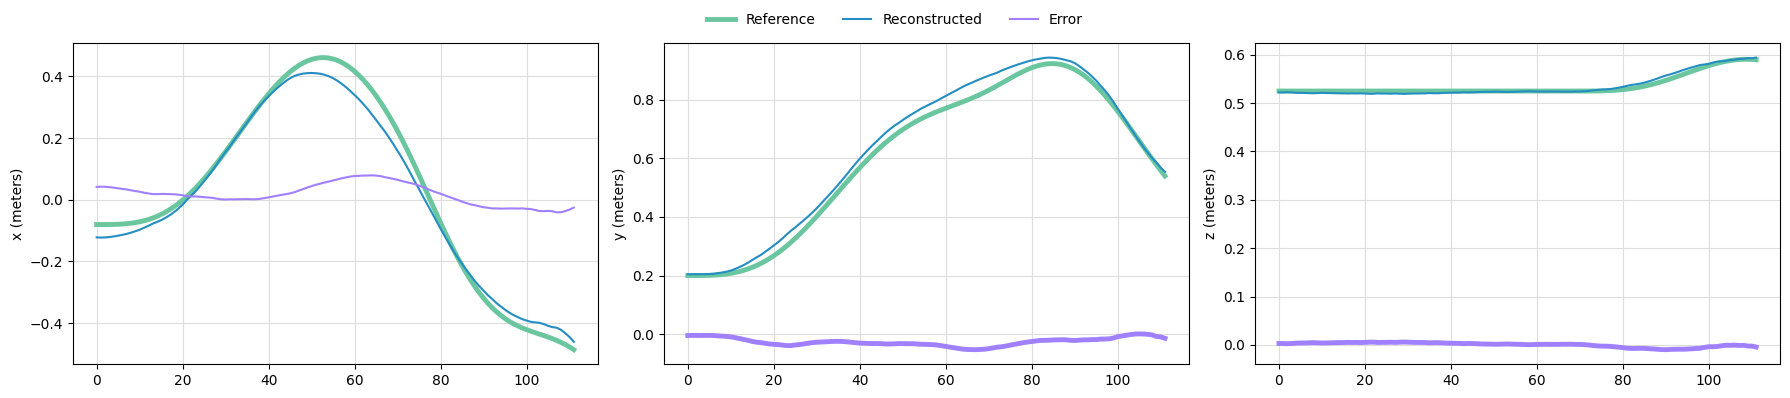

In [69]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(ref_pos[:, 0], label='Reference', linewidth=3.5)
plt.plot(reconstructed[:, 0], label='Reconstructed', linewidth=1.5)
plt.plot(ref_pos[:, 0] - reconstructed[:, 0], label='Error', linewidth=1.5)
plt.ylabel("x (meters)")
plt.grid()
plt.subplot(132)
plt.plot(ref_pos[:, 1], label='Reference', linewidth=3.5)
plt.plot(reconstructed[:, 1], label='Reconstructed', linewidth=1.5)
plt.plot(ref_pos[:, 1] - reconstructed[:, 1], label='Error', linewidth=3.5)
plt.ylabel("y (meters)")
plt.grid()
plt.subplot(133)
plt.plot(ref_pos[:, 2], label='Reference', linewidth=3.5)
plt.plot(reconstructed[:, 2], label='Reconstructed', linewidth=1.5)
plt.plot(ref_pos[:, 2] - reconstructed[:, 2], label='Error', linewidth=3.5)
plt.ylabel("z (meters)")
plt.grid()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.figlegend(['Reference', 'Reconstructed', 'Error'], loc='upper center', ncol=3, frameon=False)
plt.show()

### Interpolation between two samples
Adjust `beta0` and `beta1` for weighted interpolation

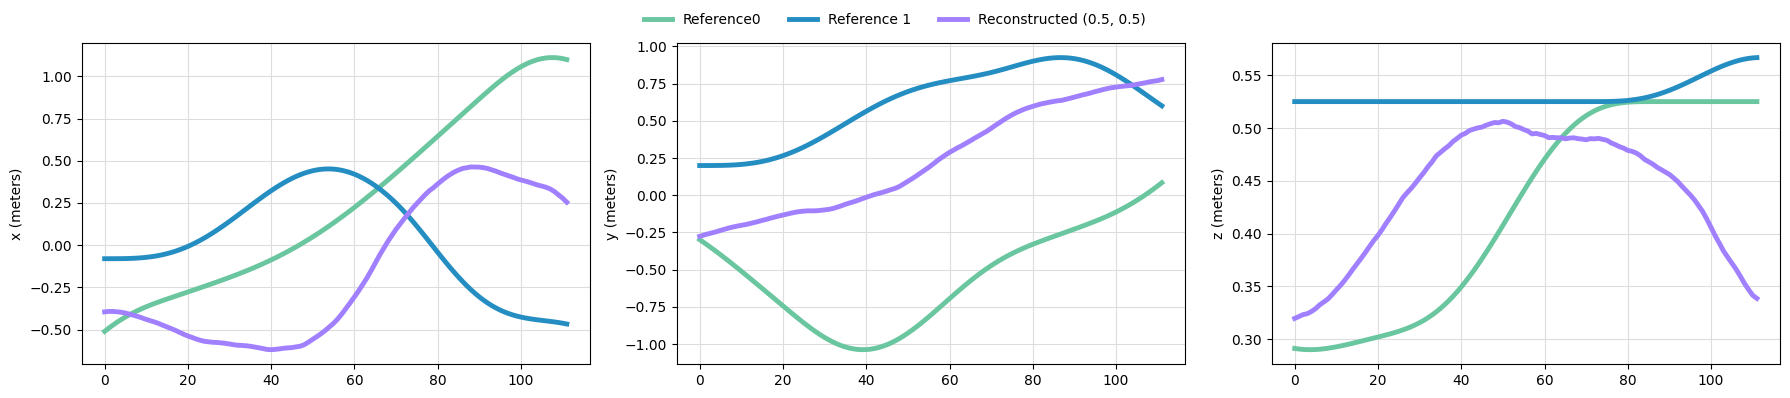

In [7]:
sample0 = data[16]
sample1 = data[117]

reference0 = normalizer.undo(sample0).numpy()
reference1 = normalizer.undo(sample1).numpy()

mu1, _ = eval.encode(sample0.unsqueeze(0).cuda())
mu2, _ = eval.encode(sample1.unsqueeze(0).cuda())

beta0 = 0.5
beta1 = 0.5
mu = beta0 * mu1 + beta1 * mu2
reconstructed = eval.decode(mu).squeeze(0).cpu().numpy()

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(reference0[:, 0], label='Reference 0', linewidth=3.5)
plt.plot(reference1[:, 0], label='Reference 1', linewidth=3.5)
plt.plot(reconstructed[:, 0], label='Reference 1', linewidth=3.5)
plt.ylabel("x (meters)")
plt.grid()
plt.subplot(132)
plt.plot(reference0[:, 1], label='Reference 0', linewidth=3.5)
plt.plot(reference1[:, 1], label='Reference 1', linewidth=3.5)
plt.plot(reconstructed[:, 1], label='Reference 1', linewidth=3.5)
plt.ylabel("y (meters)")
plt.grid()
plt.subplot(133)
plt.plot(reference0[:, 2], label='Reference 0', linewidth=3.5)
plt.plot(reference1[:, 2], label='Reference 1', linewidth=3.5)
plt.plot(reconstructed[:, 2], label='Reference 1', linewidth=3.5)
plt.ylabel("z (meters)")
plt.grid()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.figlegend(['Reference0', "Reference 1", f'Reconstructed ({beta0}, {beta1})'], loc='upper center', ncol=3, frameon=False)
plt.show()


### Testing adding noise to latent trajectory

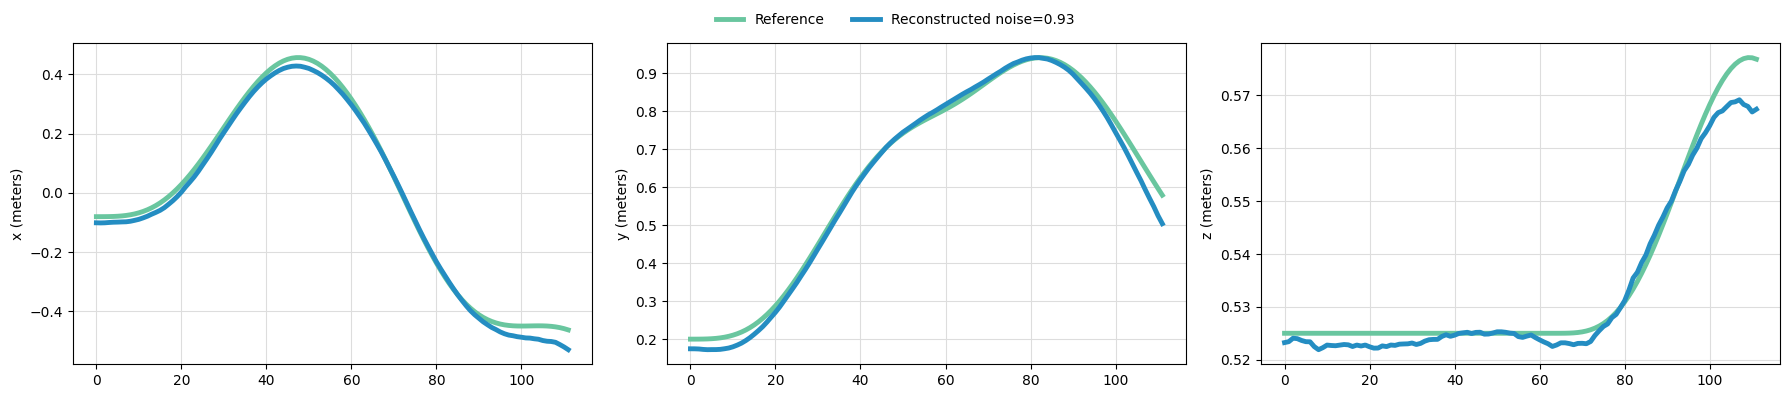

In [8]:
sample0 = data[0]

reference0 = normalizer.undo(sample0).numpy()

mu, logvar = eval.encode(sample0.unsqueeze(0).cuda())
noise = torch.randn_like(mu)
n_l = 1.0
std = n_l * torch.exp(0.5 * logvar)
mu_noise = mu + std * noise

reconstructed = eval.decode(mu_noise).squeeze(0).cpu().numpy()

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(reference0[:, 0], label='Reference 0', linewidth=3.5)
plt.plot(reconstructed[:, 0], label='Reference 1', linewidth=3.5)
plt.ylabel("x (meters)")
plt.grid()
plt.subplot(132)
plt.plot(reference0[:, 1], label='Reference 0', linewidth=3.5)
plt.plot(reconstructed[:, 1], label='Reference 1', linewidth=3.5)
plt.ylabel("y (meters)")
plt.grid()
plt.subplot(133)
plt.plot(reference0[:, 2], label='Reference 0', linewidth=3.5)
plt.plot(reconstructed[:, 2], label='Reference 1', linewidth=3.5)
plt.ylabel("z (meters)")
plt.grid()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.figlegend(['Reference', f"Reconstructed noise={std.mean():.2f}"], loc='upper center', ncol=2, frameon=False)
plt.show()


## Visualizing Latent Space

In [47]:
tokens = [list() for _ in range(16)]

for idx in random.sample(range(len(data)), 1000):
    sample = data[idx]
    inp = sample.float().unsqueeze(0).cuda()
    mu, _ = eval.encode(inp)
    for j in range(16):
        tokens[j].append(mu.squeeze(0).cpu().numpy()[j])

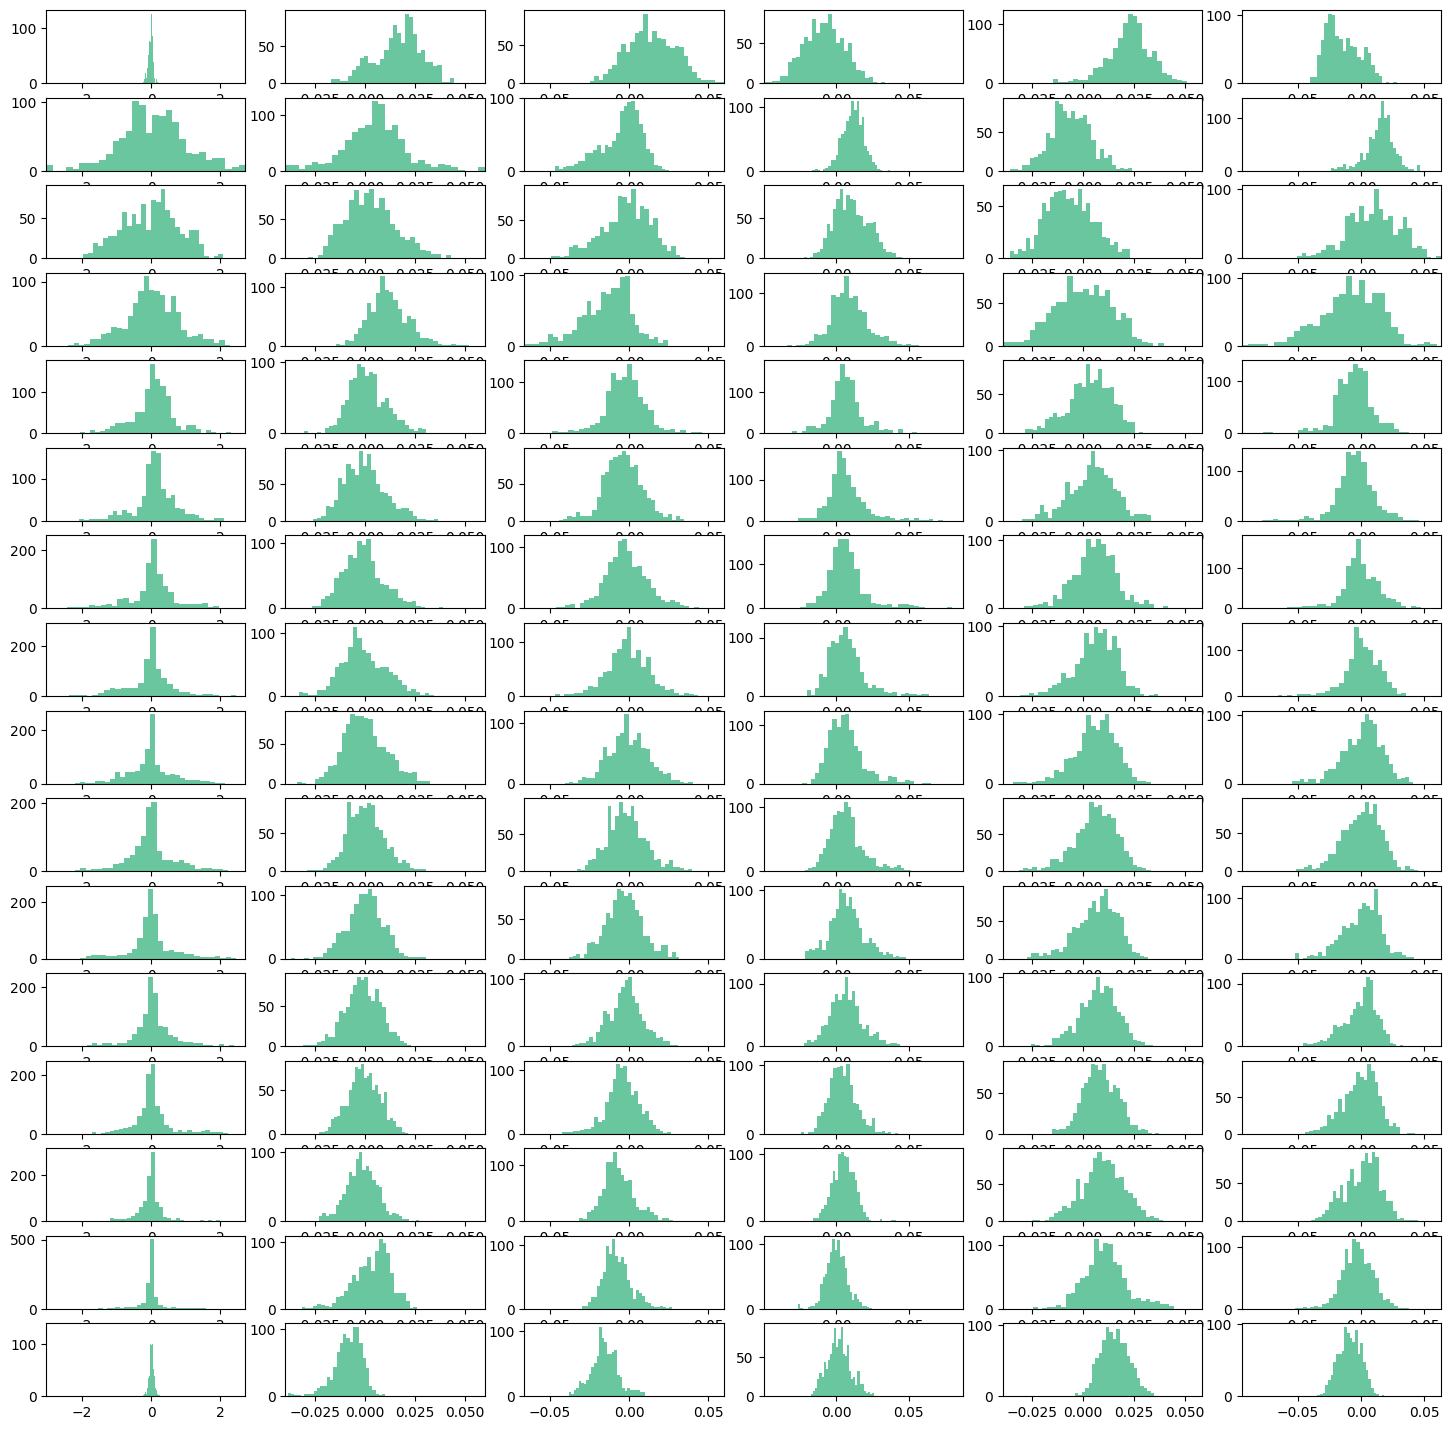

In [51]:
fig, axs = plt.subplots(16, 6, figsize=(18, 18))
all_data = [[] for _ in range(6)]
for i in range(16):
    arr = np.array(tokens[i])
    for j in range(6):
        all_data[j].extend(arr[:, j])
lims = [(np.min(d), np.max(d)) for d in all_data]
max_counts = []
for j in range(6):
    counts, _ = np.histogram(all_data[j], bins=30)
    max_counts.append(np.max(counts))
for i in range(16):
    arr = np.array(tokens[i])
    for j in range(6):
        axs[i, j].hist(arr[:, j], bins=30)
        axs[i, j].set_xlim(lims[j])
plt.show()

/tmp/ipykernel_310228/2475137314.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(sample).float().unsqueeze(0).cuda()


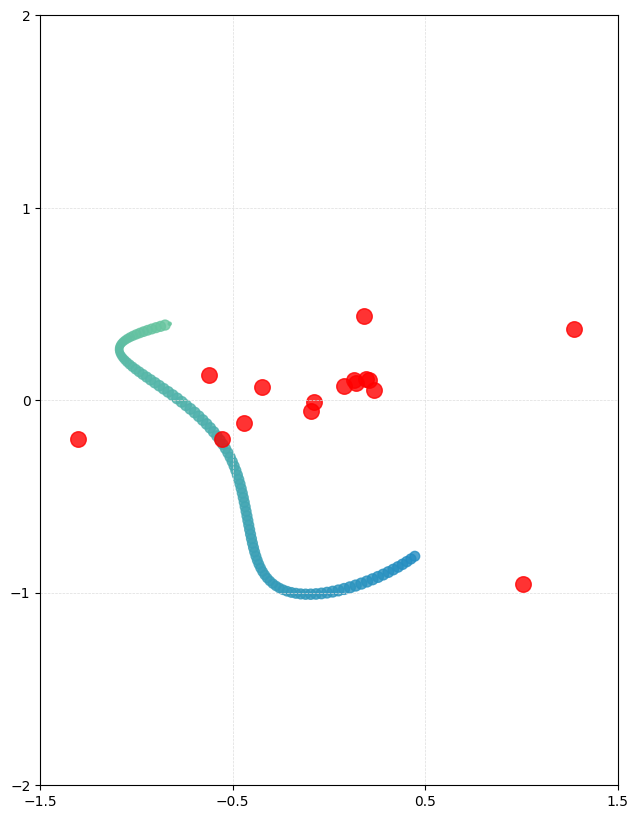

In [ ]:
sample = data[-2]
ref_pos = normalizer.undo(sample)
inp = torch.tensor(sample).float().unsqueeze(0).cuda()
mu, _ = eval.encode(inp)
mu = mu.squeeze(0).cpu().numpy()
pca = PCA(n_components=3)
mu_2d = pca.fit_transform(mu)[:, :2]

fig, ax = plt.subplots(figsize=(8, 10))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

ax.set_xticks(np.arange(-1.5, 1.6, 1))
ax.set_yticks(np.arange(-2, 2.1, 1))
ax.grid(which='both', linestyle='--', linewidth=0.5)

ref_vel = derive_trajectory(ref_pos, 30, order=1)
point_sizes, colors = get_render_map(ref_vel, max_point_size=125, min_point_size=5)
plt.scatter(ref_pos[:, 0], ref_pos[:, 1], s=point_sizes, c=colors, marker='o', alpha=0.8)

vel = derive_trajectory(mu_2d, 1, order=1)
plt.scatter(mu_2d[:, 0], mu_2d[:, 1], s=125, c='red', marker='o', alpha=0.8)

In [ ]:
N = 1000
start = time.time()
for _ in range(N):
    trajectory = torch.randn(
        (1, 384 // (2**(len(eval.args[1].channel_mults) - 1)), eval.args[1].latent_dim)).cuda()
    _ = eval.decode(trajectory)
end = time.time() - start
print(f"{end / N:.4f} seconds on avg to decode 1 sample")

0.0089 seconds on avg to decode 1 sample


In [ ]:
# Cell 1
all_courses = []
all_indices = []
course_types = ["pill","triangle","square"]
batch_size = 1000
for mode in course_types:
    data = QuadrotorRaceSegmentDataset('../data', [mode], 112, 0, normalizer)
    course_mu = []
    course_ids = []
    for i in range(0,len(data),batch_size):
        batch_samples = []
        idxs = []
        for j in range(i,min(i+batch_size,len(data))):
            sample = data[j]
            inp = torch.tensor(sample).float()
            padding = 32
            top_row = inp[0].unsqueeze(0).repeat(padding,1)
            bottom_row = inp[-1].unsqueeze(0).repeat(padding,1)
            inp = torch.cat([top_row,inp,bottom_row],dim=0).unsqueeze(0)
            batch_samples.append(inp)
            idxs.append(j)
        batch = torch.cat(batch_samples,dim=0).cuda()
        mu,_ = eval.encode(batch)
        mu_flat = mu.reshape(mu.size(0),-1).cpu().numpy()
        course_mu.append(mu_flat)
        course_ids.append(np.array(idxs))
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    all_courses.append(np.concatenate(course_mu,axis=0))
    all_indices.append(np.concatenate(course_ids,axis=0))

/tmp/ipykernel_310228/2912647670.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(sample).float()


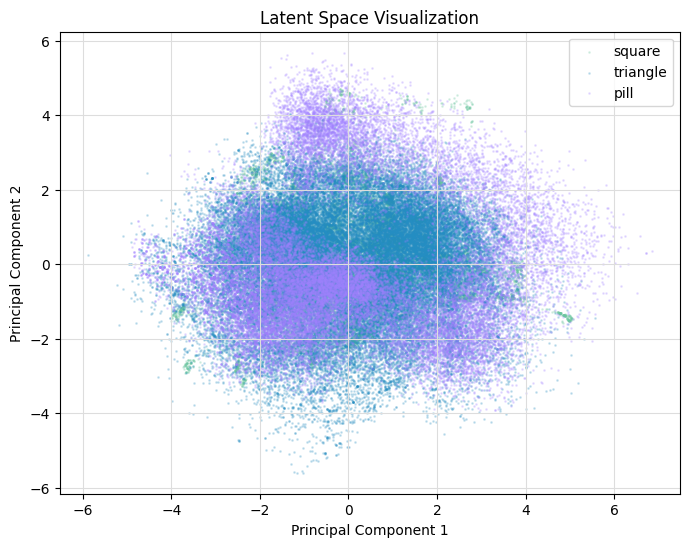

In [ ]:
pca = PCA(n_components=2)
latent_spaces = [pca.fit_transform(mu_flat) for mu_flat in all_courses]
plt.figure(figsize=(8,6))
for latent_space,course_type in zip(latent_spaces[::-1],course_types[::-1]):
    plt.scatter(latent_space[:,0],latent_space[:,1],alpha=0.2,s=1,label=course_type)
legend = plt.legend()
plt.title('Latent Space Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

/u/cbf2xv/.conda/envs/qdiff2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/u/cbf2xv/.conda/envs/qdiff2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/u/cbf2xv/.conda/envs/qdiff2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


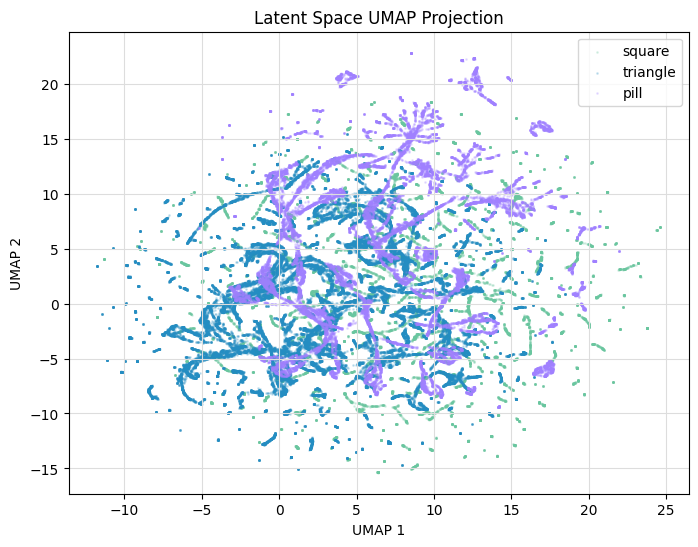

In [ ]:
umap_spaces = [umap.UMAP(n_components=2).fit_transform(mu_flat) for mu_flat in all_courses]
plt.figure(figsize=(8,6))
for umap_space, course_type in zip(umap_spaces[::-1], course_types[::-1]):
    plt.scatter(umap_space[:,0], umap_space[:,1], alpha=0.2, s=1, label=course_type)
plt.legend()
plt.title('Latent Space UMAP Projection')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid()
plt.show()  

# Im not sure what to call this section

In [5]:
from quadrotor_diffusion.utils.dataset.boundary_condition import PolynomialTrajectory
from quadrotor_diffusion.utils.file import load_course_trajectory

course: np.ndarray = None
trajectory: PolynomialTrajectory = None
course, trajectory, filename = load_course_trajectory("triangle", 13, 0)
print(f"Loaded trajectory from {filename}")

trajectory.states.append(trajectory.states[2])
trajectory.segment_lengths.append(trajectory.segment_lengths[1])
trajectory.states.append(trajectory.states[3])
trajectory.segment_lengths.append(trajectory.segment_lengths[2])
ref_pos = trajectory.as_ref_pos()

Loaded trajectory from ../data/courses/triangle/13/valid/0_(8.50).pkl


In [6]:
gate_idx = 0
vae_segments = []
start_idx = 0
for idx, segment_length in enumerate(trajectory.segment_lengths):
    starting_gate = trajectory.states[idx]
    end_state = trajectory.states[idx+1]
    new_gate_idx = int(30 * segment_length)
    
    
    rp_slice = ref_pos[max(0, gate_idx - 5):gate_idx+112]
    dist_to_start_gate = np.linalg.norm(rp_slice - np.array([starting_gate.x.s, starting_gate.y.s, starting_gate.z.s]), axis=1)
    
    vae_segments.append((start_idx, start_idx + 112, end_state))
    
    ending_idx = np.argmin(
        np.linalg.norm(
            ref_pos[start_idx:start_idx+112] - np.array([end_state.x.s, end_state.y.s, end_state.z.s]),
            axis=1,
        )
    )
    start_idx = start_idx + ending_idx
    
    gate_idx += new_gate_idx

raw_inps = []
raw_recons = []
next_gate_idx = []

for start_idx, end_idx, end_state in vae_segments[:-1]:
    inp = ref_pos[start_idx:end_idx]
    inp = normalizer(inp)
    inp = torch.tensor(inp).float().unsqueeze(0).cuda()

    mu, _ = eval.encode(inp)
    x_recon = eval.decode(mu).squeeze(0).cpu().numpy()
    x_recon = normalizer.undo(x_recon)
    
    inp = ref_pos[start_idx:end_idx]
    raw_inps.append(inp)
    raw_recons.append(x_recon)
    
    ending_idx = np.argmin(
        np.linalg.norm(
            inp - np.array([end_state.x.s, end_state.y.s, end_state.z.s]),
            axis=1,
        )
    )
    
    next_gate_idx.append((ending_idx, end_state))

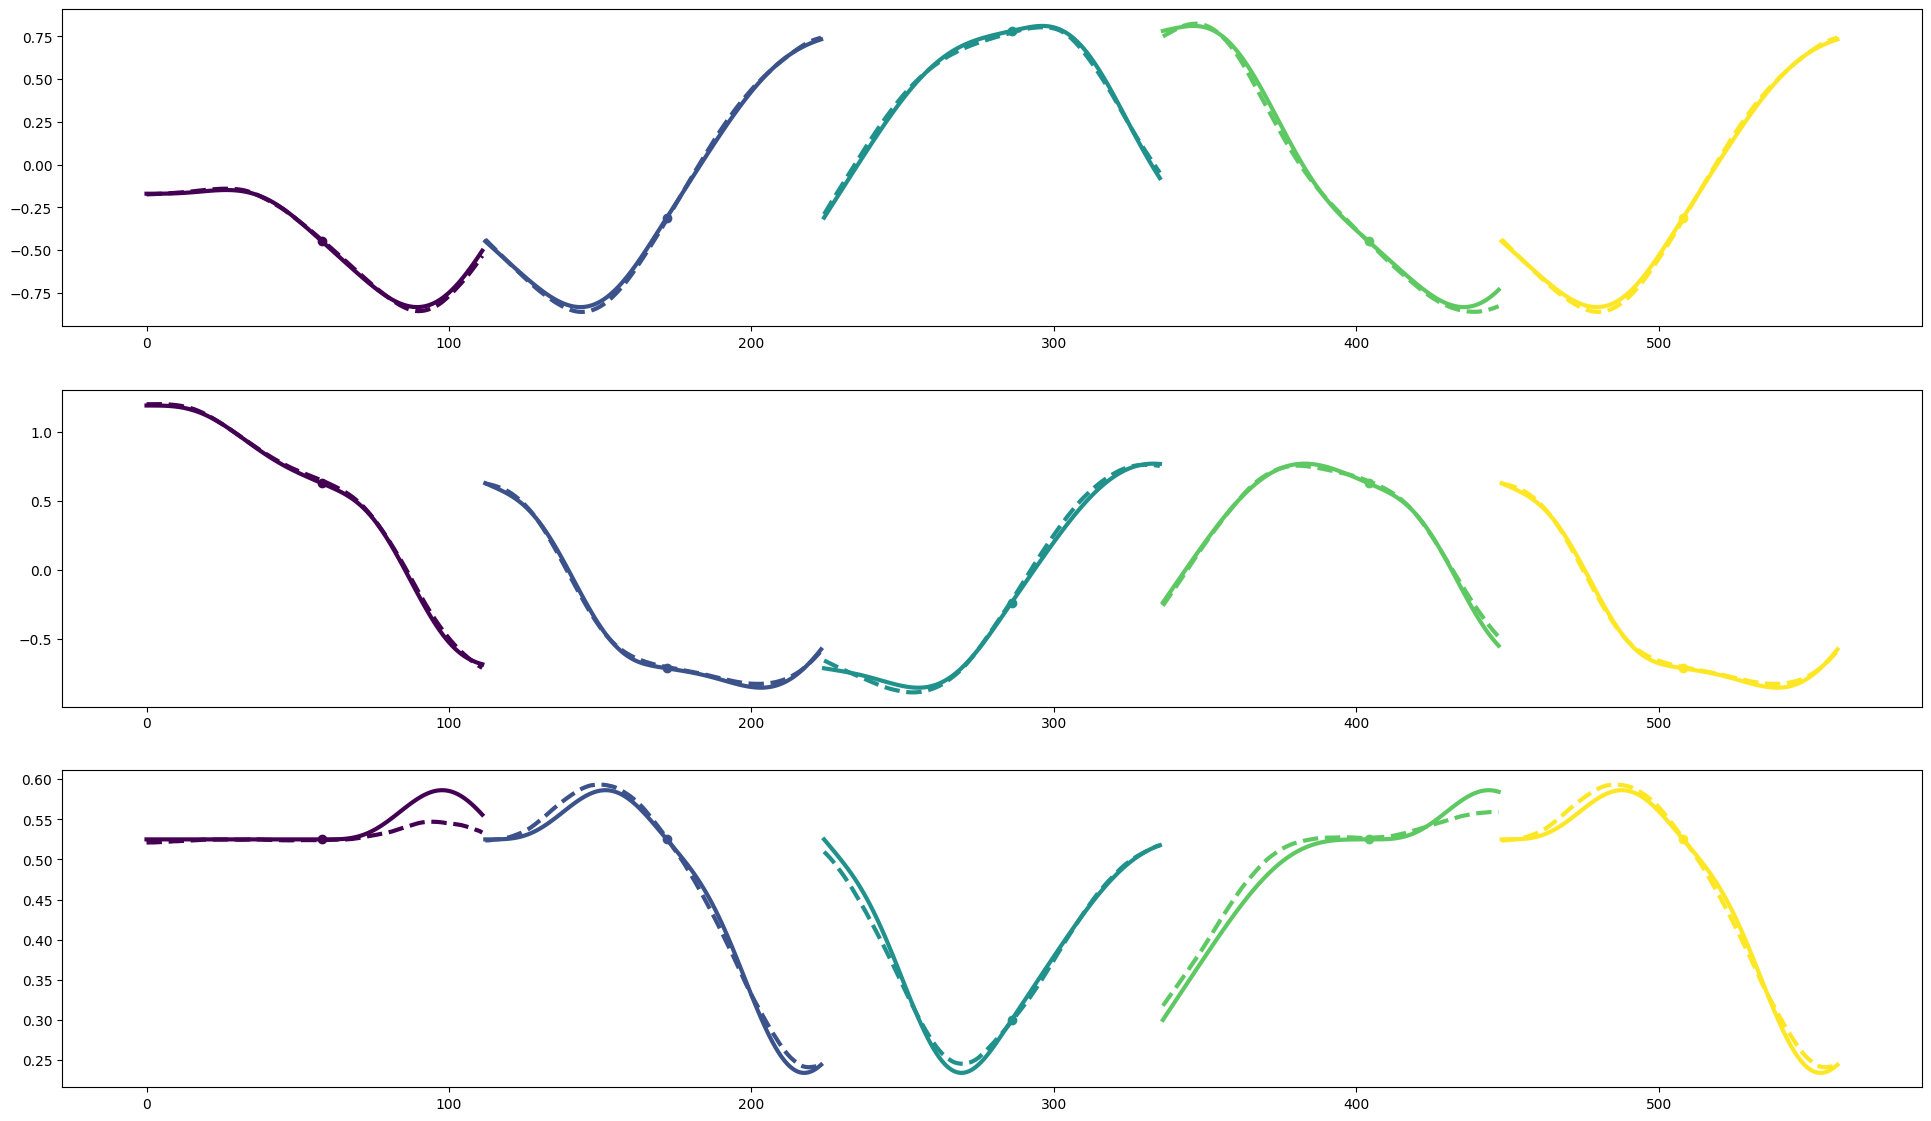

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(24, 14))
colors = plt.cm.viridis(np.linspace(0, 1, len(raw_inps)))
x_offset = 0
for i, (inp, recon, (gate_idx, gate_state)) in enumerate(zip(raw_inps, raw_recons, next_gate_idx)):
    x_inp = np.arange(x_offset, x_offset + len(inp))
    for j in range(3):
        axs[j].plot(x_inp, inp[:, j], color=colors[i], linewidth=3)
        axs[j].plot(x_inp, recon[:, j], '--', color=colors[i], linewidth=3)

    axs[0].scatter(x_offset + gate_idx, gate_state.x.s, color=colors[i])
    axs[1].scatter(x_offset + gate_idx, gate_state.y.s, color=colors[i])
    axs[2].scatter(x_offset + gate_idx, gate_state.z.s, color=colors[i])
    
    x_offset += len(inp)
plt.show()

0.00022172927856445312


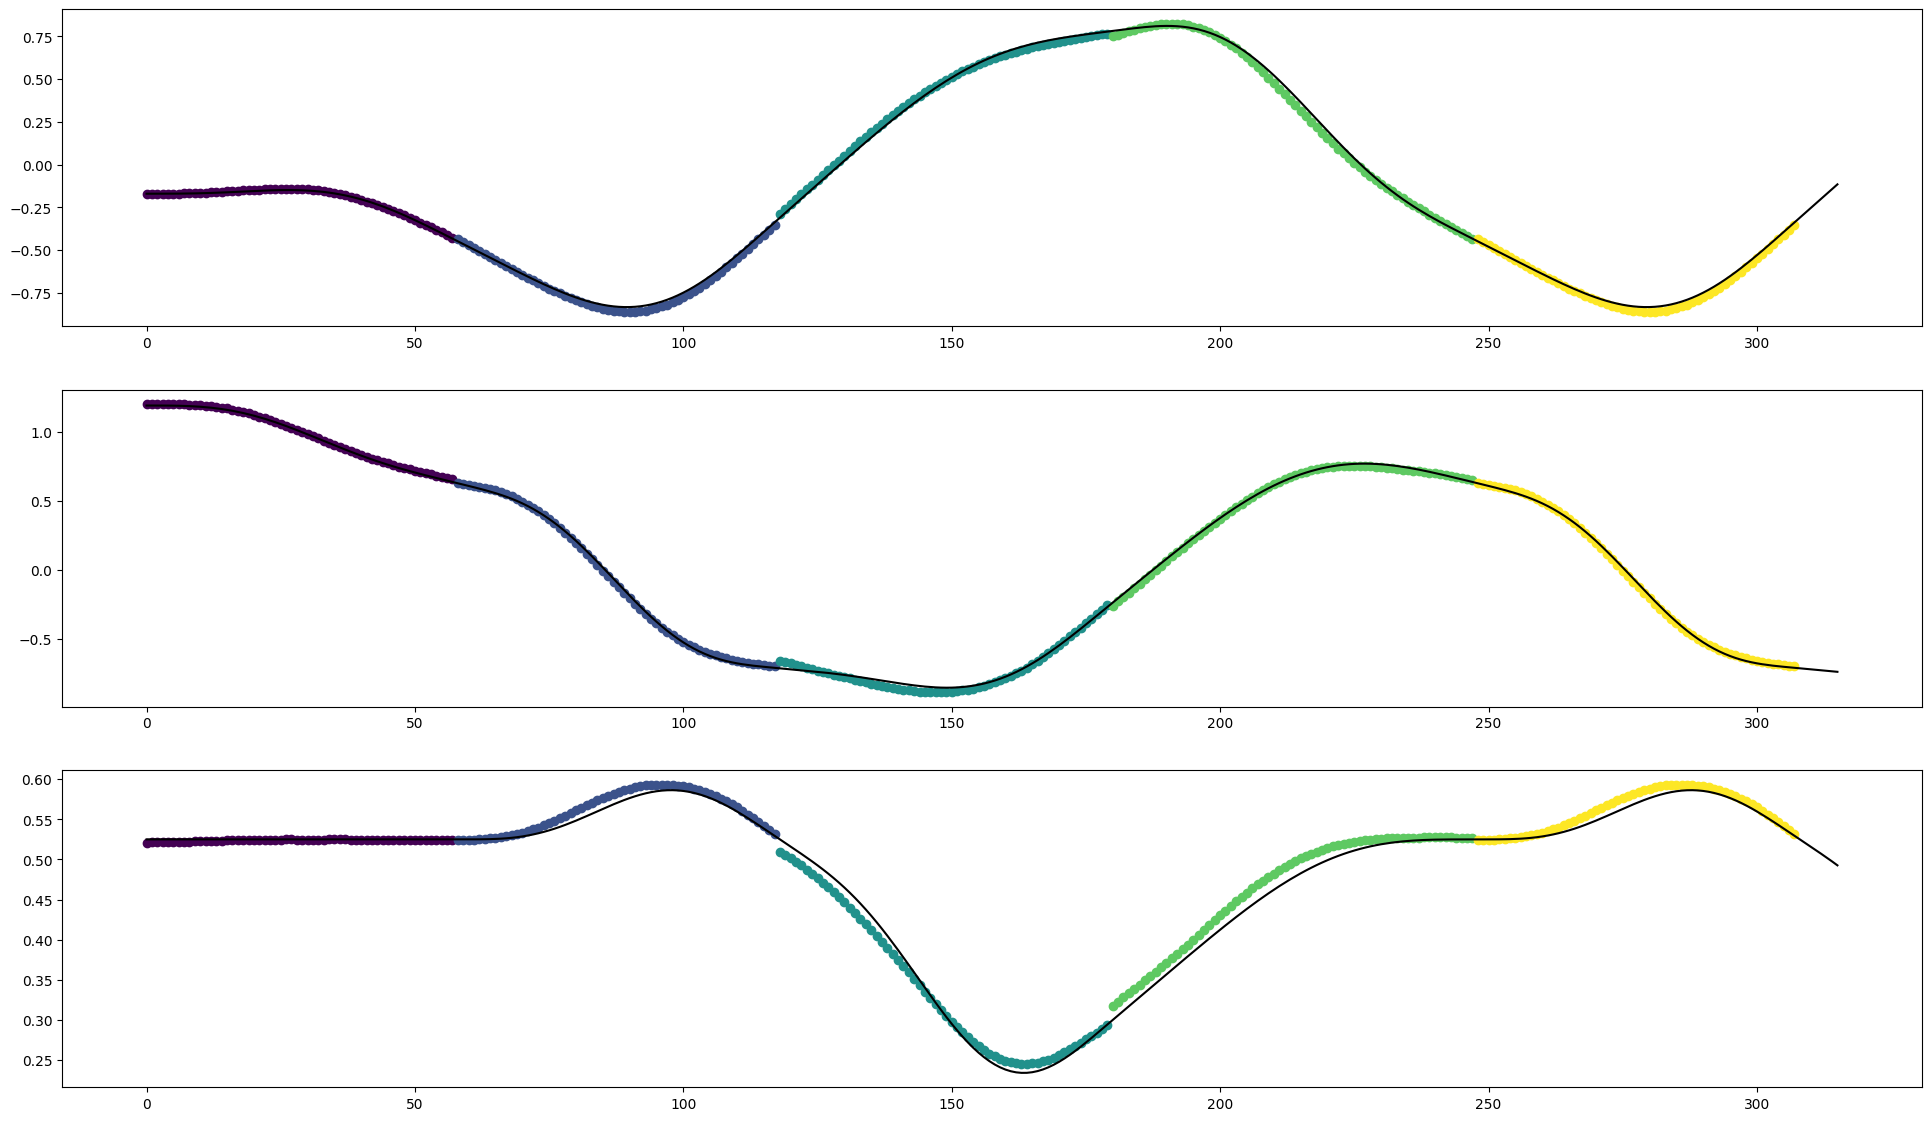

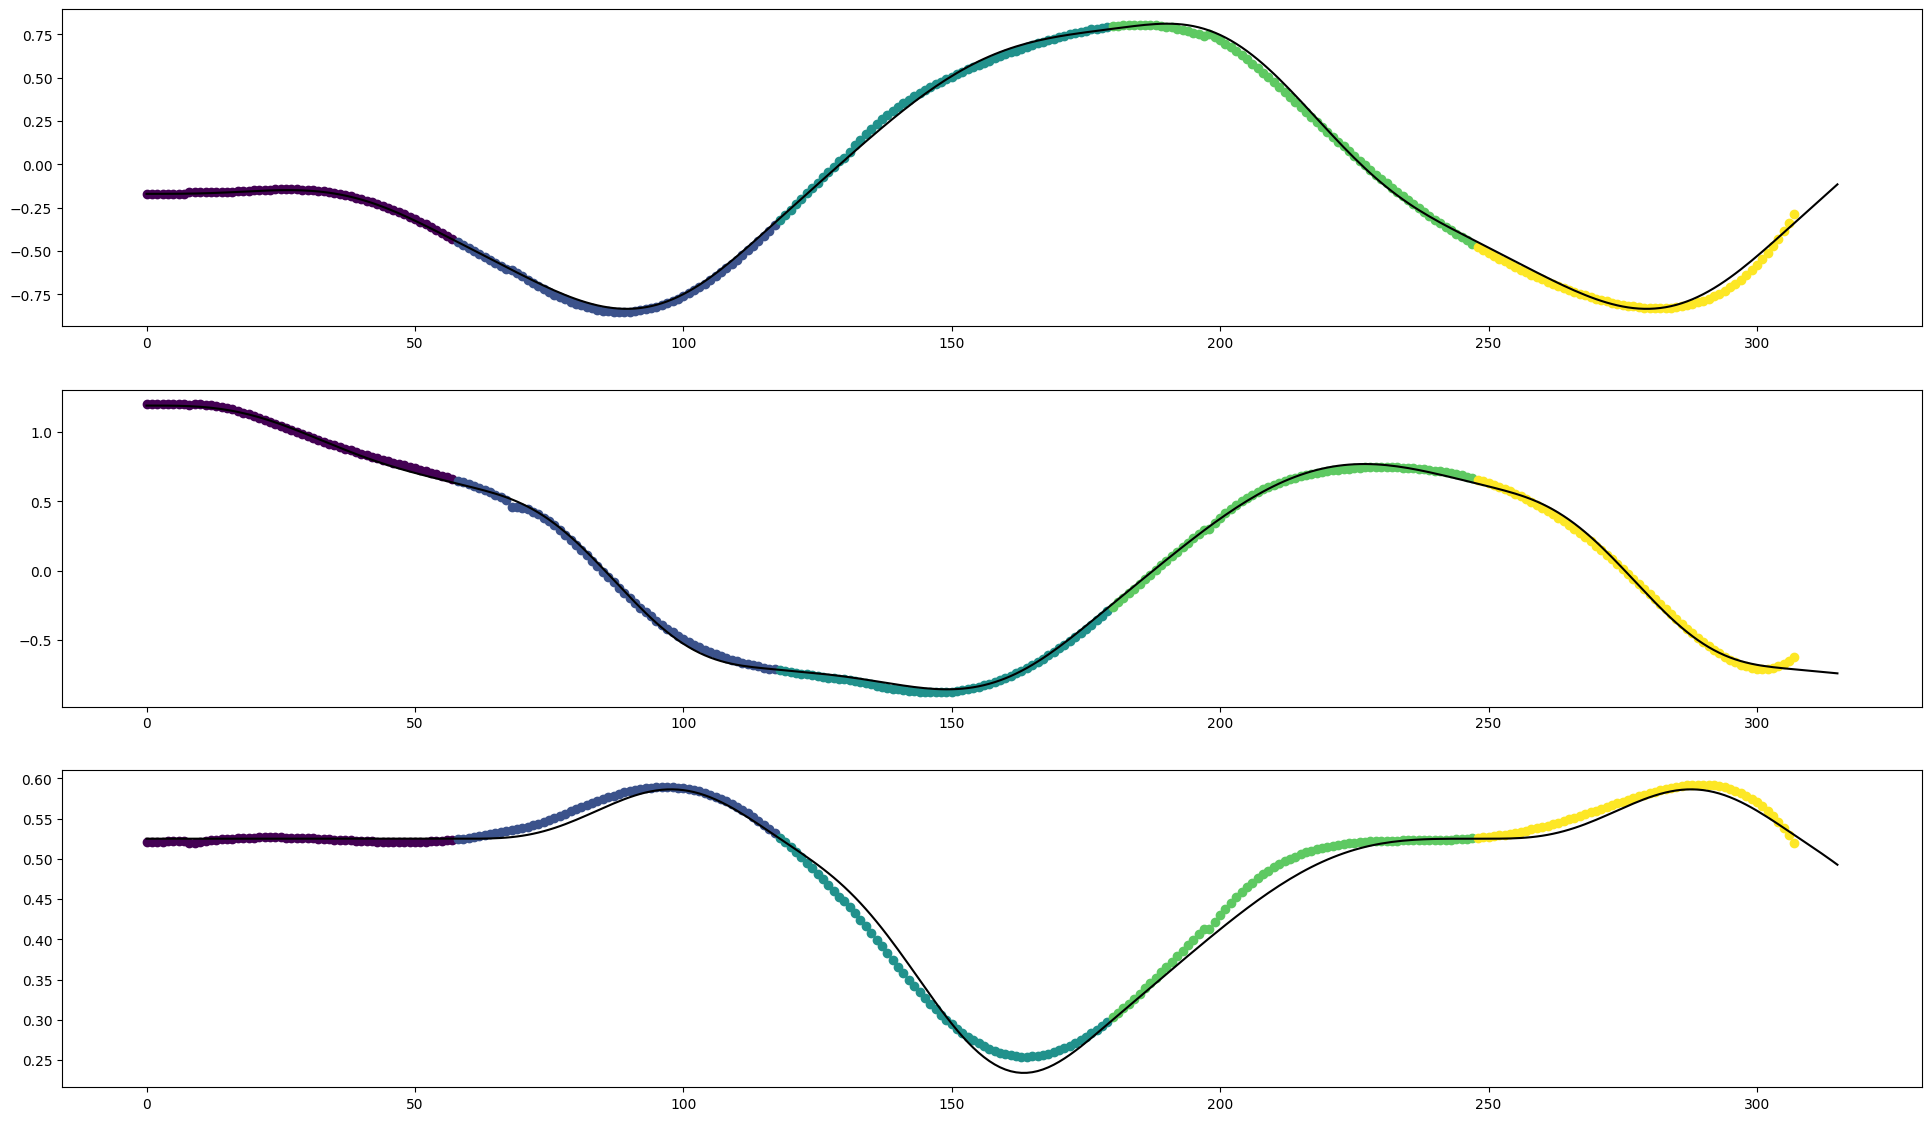

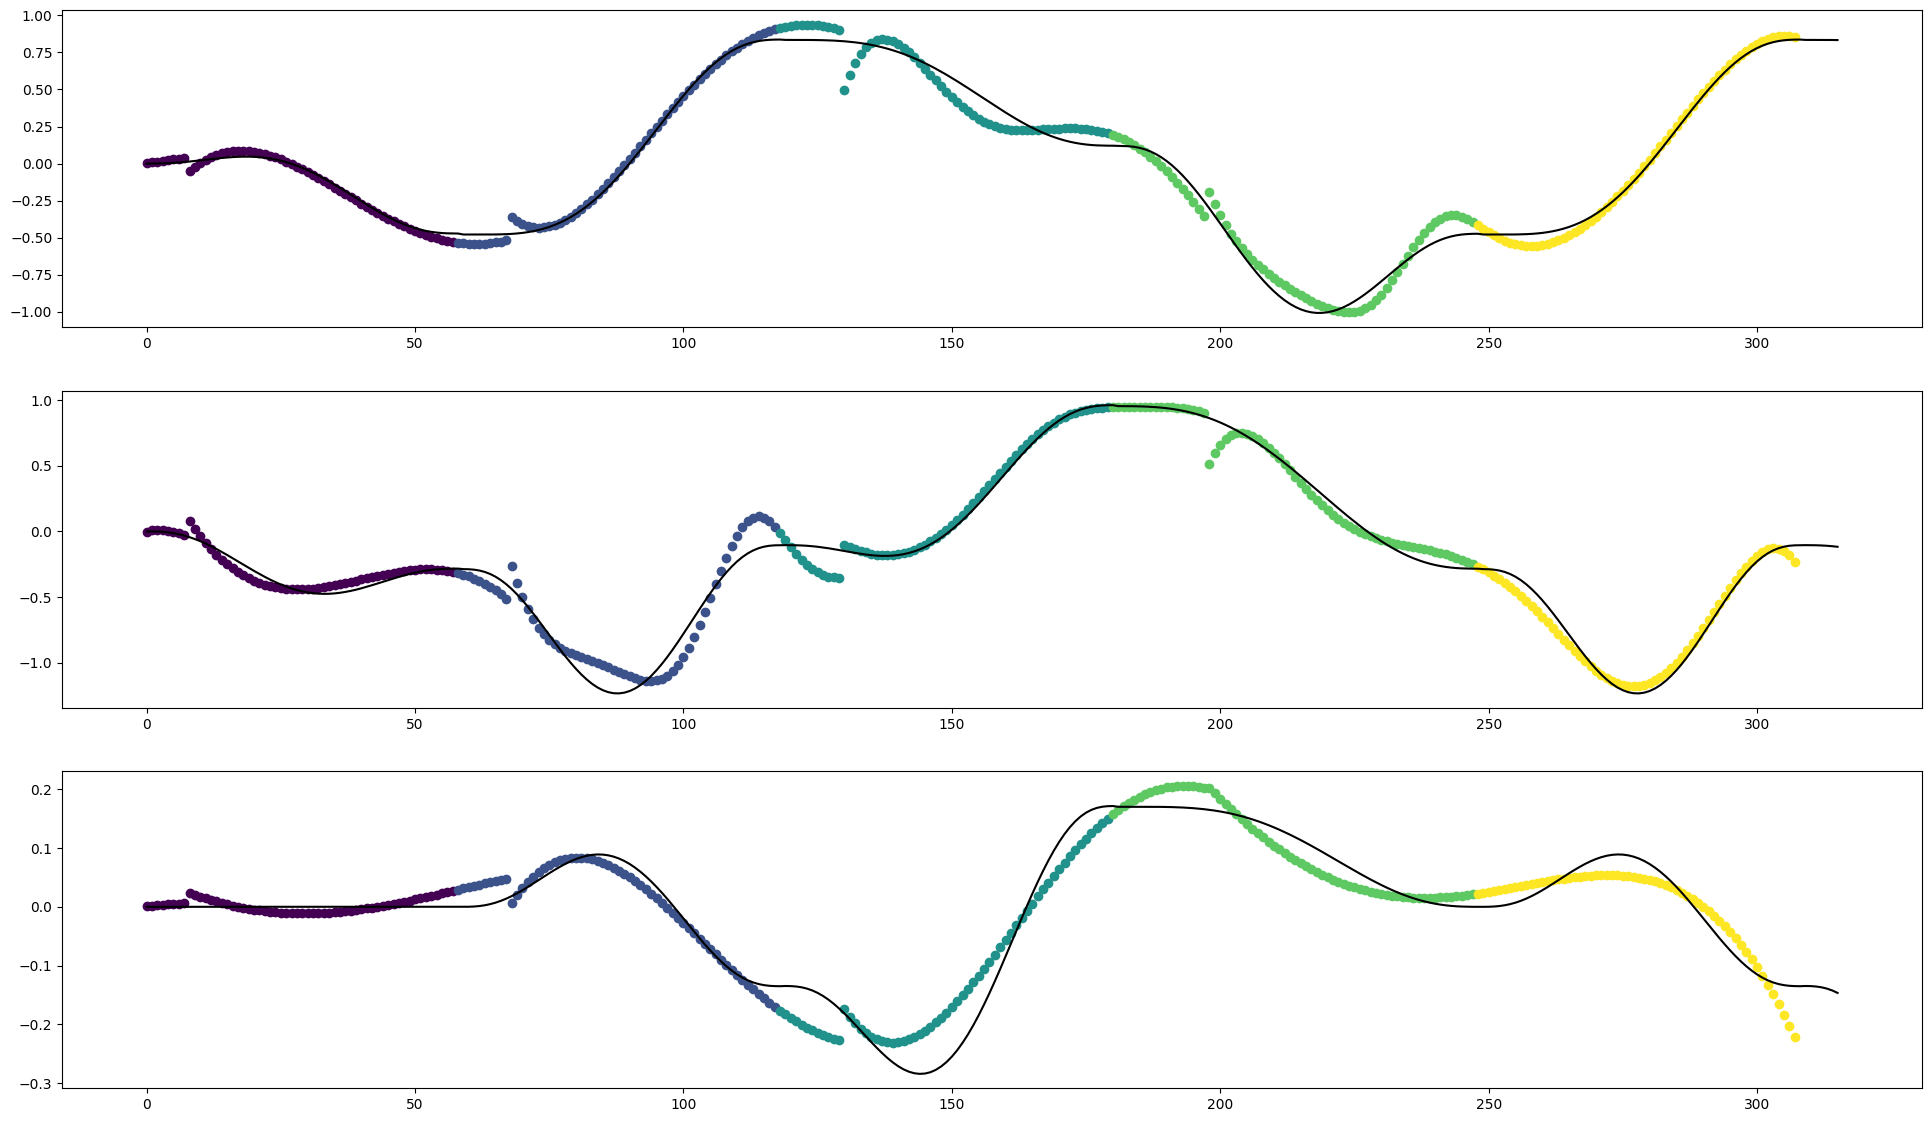

In [37]:
import time
s = time.time()
recons_modified = []
for raw_recon, (end_idx, _) in zip(raw_recons, next_gate_idx):
    recon_trimmed = raw_recon[:end_idx]
    recons_modified.append(
        recon_trimmed
    )
    
recons_modified_smoothed = []
velocity_modified_smoothed = []
print(time.time() - s)

for idx in range(len(recons_modified)):
    if idx == 0:
        fitted = fit_to_recon(recons_modified[idx], 30)
        recons_modified_smoothed.append(fitted[0])
        velocity_modified_smoothed.append(fitted[1])
        continue
    
    OVERLAP = 50
    
    old_segment = recons_modified_smoothed[idx - 1]
    segment = np.vstack((old_segment[-OVERLAP:], recons_modified[idx]))
    fitted = fit_to_recon(segment, 30)
    recons_modified_smoothed.append(fitted[0][OVERLAP:])
    velocity_modified_smoothed.append(fitted[1][OVERLAP:])
    
    old_segment[-OVERLAP:] = fitted[0][:OVERLAP]
    recons_modified_smoothed[idx - 1] = old_segment
    
    old_velocity = velocity_modified_smoothed[idx - 1]
    old_velocity[-OVERLAP:] = fitted[1][:OVERLAP]
    velocity_modified_smoothed[idx - 1] = old_velocity
    
    
fig, axs = plt.subplots(3, 1, figsize=(24, 14))
colors = plt.cm.viridis(np.linspace(0, 1, len(recons_modified)))
x_offset = 0
for i, recon in enumerate(recons_modified):
    x_inp = np.arange(x_offset, x_offset + len(recon))
    for j in range(3):
        axs[j].scatter(x_inp, recon[:, j], color=colors[i])

    x_offset += len(recon)

rp_slice = ref_pos[:int(sum(trajectory.segment_lengths[:-1]) * 30)]
axs[0].plot(np.arange(len(rp_slice)), rp_slice[:, 0], color='black')
axs[1].plot(np.arange(len(rp_slice)), rp_slice[:, 1], color='black')
axs[2].plot(np.arange(len(rp_slice)), rp_slice[:, 2], color='black')

plt.show()

recons_trimmed = recons_modified
recons_modified = recons_modified_smoothed
    
fig, axs = plt.subplots(3, 1, figsize=(24, 14))
colors = plt.cm.viridis(np.linspace(0, 1, len(recons_modified)))
x_offset = 0
for i, recon in enumerate(recons_modified):
    x_inp = np.arange(x_offset, x_offset + len(recon))
    for j in range(3):
        axs[j].scatter(x_inp, recon[:, j], color=colors[i])

    x_offset += len(recon)

rp_slice = ref_pos[:int(sum(trajectory.segment_lengths[:-1]) * 30)]
axs[0].plot(np.arange(len(rp_slice)), rp_slice[:, 0], color='black')
axs[1].plot(np.arange(len(rp_slice)), rp_slice[:, 1], color='black')
axs[2].plot(np.arange(len(rp_slice)), rp_slice[:, 2], color='black')

plt.show()

fig, axs = plt.subplots(3, 1, figsize=(24, 14))
colors = plt.cm.viridis(np.linspace(0, 1, len(velocity_modified_smoothed)))
x_offset = 0
for i, recon in enumerate(velocity_modified_smoothed):
    x_inp = np.arange(x_offset, x_offset + len(recon))
    for j in range(3):
        axs[j].scatter(x_inp, recon[:, j], color=colors[i])

    x_offset += len(recon)

rp_slice = derive_trajectory(ref_pos[:int(sum(trajectory.segment_lengths[:-1]) * 30)], 30)
axs[0].plot(np.arange(len(rp_slice)), rp_slice[:, 0], color='black')
axs[1].plot(np.arange(len(rp_slice)), rp_slice[:, 1], color='black')
axs[2].plot(np.arange(len(rp_slice)), rp_slice[:, 2], color='black')

plt.show()

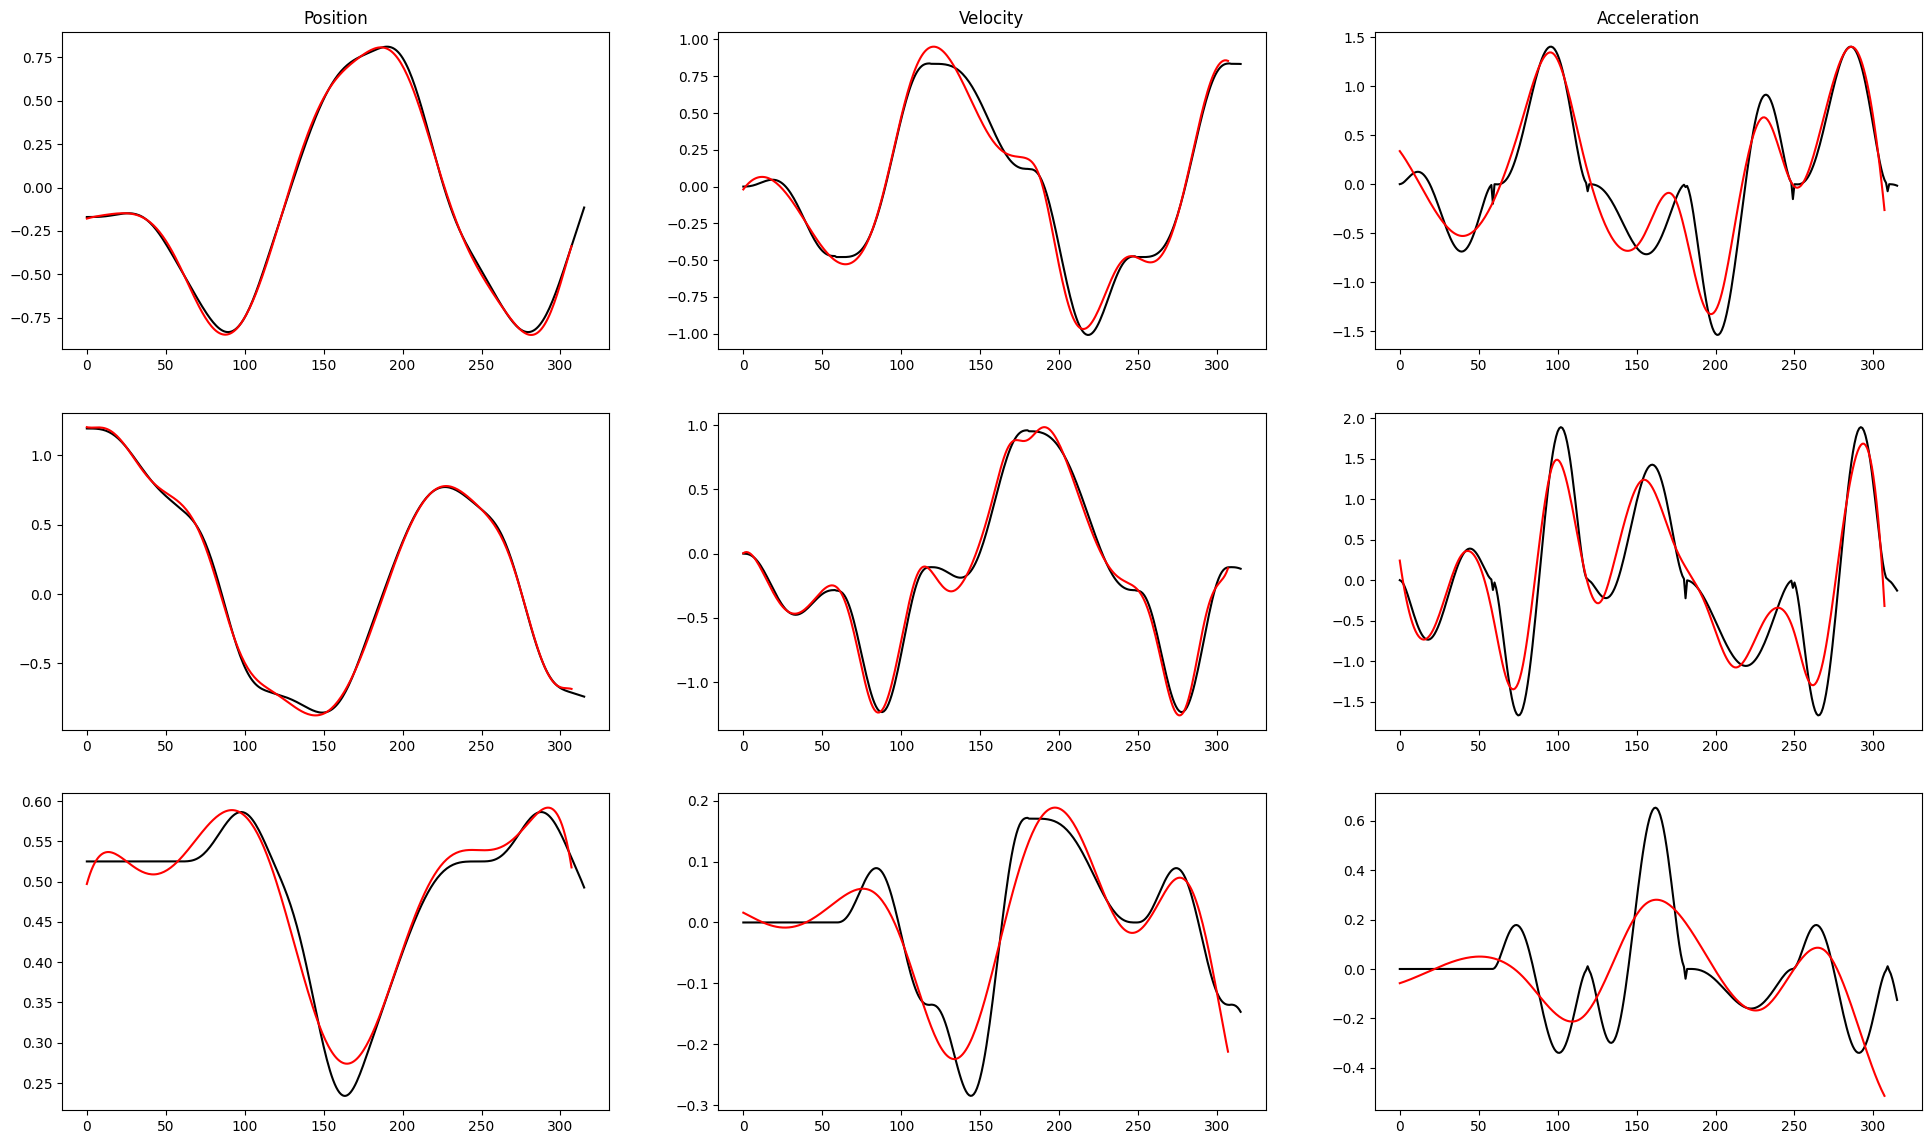

In [13]:
fitted = fit_to_recon(np.vstack(recons_trimmed), 30)

fig, axs = plt.subplots(3,3,figsize=(24,14))
rp_slice = ref_pos[:int(sum(trajectory.segment_lengths[:-1])*30)]
for i in range(3):
    axs[i,0].plot(np.arange(len(rp_slice)), rp_slice[:,i], c='k')
    axs[i,0].plot(np.arange(len(fitted[0])), fitted[0][:,i], c='r')
rp_slice = derive_trajectory(ref_pos[:int(sum(trajectory.segment_lengths[:-1])*30)], 30, 1)
for i in range(3):
    axs[i,1].plot(np.arange(len(rp_slice)), rp_slice[:,i], c='k')
    axs[i,1].plot(np.arange(len(fitted[1])), fitted[1][:,i], c='r')
rp_slice = derive_trajectory(ref_pos[:int(sum(trajectory.segment_lengths[:-1])*30)], 30, 2)
for i in range(3):
    axs[i,2].plot(np.arange(len(rp_slice)), rp_slice[:,i], c='k')
    axs[i,2].plot(np.arange(len(fitted[2])), fitted[2][:,i], c='r')
axs[0,0].set_title('Position')
axs[0,1].set_title('Velocity')
axs[0,2].set_title('Acceleration')
plt.show()


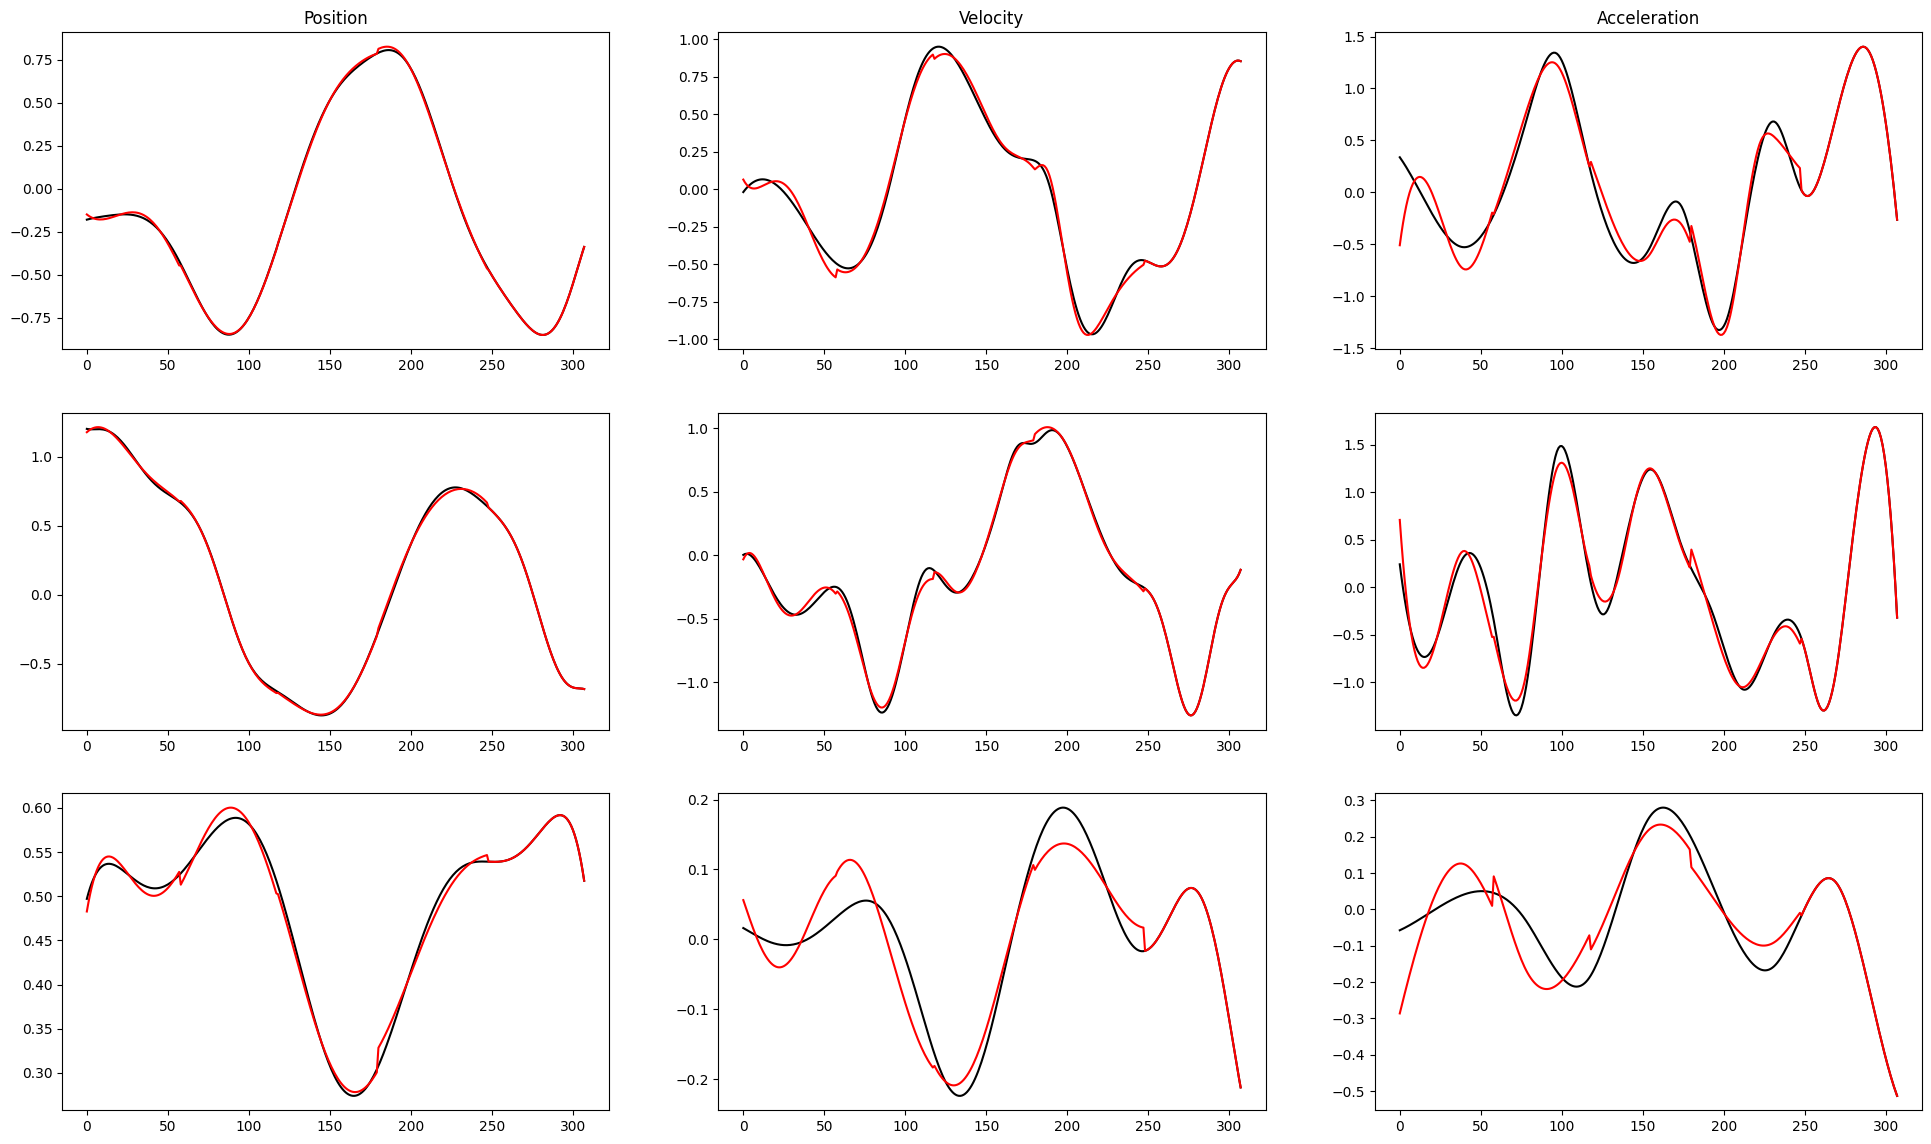

In [36]:
import copy

idx = 3
sizes = [len(recon) for recon in recons_trimmed]
fitted_new = copy.deepcopy(fitted)

for idx in range(4):
    new_inp = copy.deepcopy(fitted_new[0])

    new_inp[sum(sizes[:idx]):sum(sizes[:idx+1])] = recons_trimmed[idx]
    new_inp_fitted = fit_to_recon(new_inp, 30)

    fitted_new = copy.deepcopy(fitted_new)

    for i in range(3):
        fitted_new[i][sum(sizes[:idx]):sum(sizes[:idx+1])] = new_inp_fitted[i][sum(sizes[:idx]):sum(sizes[:idx+1])]

fig, axs = plt.subplots(3,3,figsize=(24,14))
rp_slice = ref_pos[:int(sum(trajectory.segment_lengths[:-1])*30)]
for i in range(3):
    axs[i,0].plot(np.arange(len(fitted[0])), fitted[0][:, i], c='k')
    axs[i,0].plot(np.arange(len(fitted_new[0])), fitted_new[0][:,i], c='r')
rp_slice = derive_trajectory(ref_pos[:int(sum(trajectory.segment_lengths[:-1])*30)], 30, 1)
for i in range(3):
    axs[i,1].plot(np.arange(len(fitted[1])), fitted[1][:, i], c='k')
    axs[i,1].plot(np.arange(len(fitted_new[1])), fitted_new[1][:,i], c='r')
rp_slice = derive_trajectory(ref_pos[:int(sum(trajectory.segment_lengths[:-1])*30)], 30, 2)
for i in range(3):
    axs[i,2].plot(np.arange(len(fitted[2])), fitted[2][:, i], c='k')
    axs[i,2].plot(np.arange(len(fitted_new[2])), fitted_new[2][:,i], c='r')
axs[0,0].set_title('Position')
axs[0,1].set_title('Velocity')
axs[0,2].set_title('Acceleration')
plt.show()
